Imports para utilizar numpy arrays.

In [1]:
import numpy as np

Imports para extraer datos de un archivo csv

In [2]:
import pandas as pd

Imports para dividir las fotos del dataset en entrenamiento y test.

In [3]:
from sklearn.model_selection import train_test_split

Imports para limpiar la sesion e indicar rate de aprendizaje.

In [4]:
from keras.optimizers import *

Using TensorFlow backend.


Imports para convertir la foto a un array.

In [5]:
from keras.preprocessing import image

Imports para que funcione y se imprima la matriz con los resultados.

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

Imports necesarios para que funcionen las peticiones POST al servidor.

In [7]:
from bottle import Bottle,route, run, request

Imports para que se pueda definir un modelo desde un json.

In [8]:
from keras.models import model_from_json

Imports necesarios para que funcione la CNN

In [9]:
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

Imports para archivos temporales.

In [10]:
import tempfile

Imports para abrir la foto y poder manipularla.

In [11]:
from PIL import Image

Especificamos la ruta donde se encuentra el dataset a utilizar.

In [12]:
filename = 'G:/datos/data/fer2013/fer2013.csv'

Estas son las expresiones disponibles en el dataset
- 0 : angry
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : sad
- 5 : surprise
- 6 : neutral

In [13]:
expressions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

### Funcion para comprobar la estructura del dataset.

In [14]:
def checkData():
    df=pd.read_csv(filename)
    print(df)

### Funcion para obtener los datos (X=pixels, Y=emotion) y almacenarlos en variables.

In [15]:
def getData():
    # declaramos las variables contenedoras de los pixeles (X) y de las etiquetas (Y).
    X = []
    Y = []
    # evitamos la primera linea que contiene los nombres de las columnas.
    void = True
    for line in open(filename):
        if void:
            void = False
        else:
            # dividimos la linea por la coma de forma que tenemos un array con los datos necesarios.
            fila = line.split(',')
            # apilamos los datos en las variables
            Y.append(int(fila[0]))
            X.append([int(p) for p in fila[1].split()])
    # convertimos a numpy array para tratar los datos.
    # ademas procesamos los pixeles de forma que todos tengan un valor entre 0 y 1 (dividimos entre 255).
    X = np.array(X) / 255.0
    Y = np.array(Y)
    return X, Y

### Funcion para cargar los datos del dataset y llamar a la funcion train_test_split.

In [16]:
def loadData():
    # llamamos a la funcion para obtener los datos del dataset
    X,Y = getData()
    # identificamos el numero de clases que existen(numero de expresiones faciales)
    num_class = len(set(Y))
    # redimensionamos X para que se adecue a la red neuronal (shape,size,size,gray)
    N,D = X.shape
    X = X.reshape(N, 48, 48, 1)
    # creamos variables de entrenamiento
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    Y_train = (np.arange(num_class) == Y_train[:, None]).astype(np.float32)
    Y_test = (np.arange(num_class) == Y_test[:, None]).astype(np.float32)
    return X_train,X_test,Y_train,Y_test

### Funcion que contiene el modelo CNN utilizado.

In [17]:
def my_model():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), input_shape= (48,48,1) ,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model

### Funcion que contiene otro modelo CNN que proporciona peores resultados.

In [18]:
def my_model2():
    INIT_LR = 1e-3
    
    model2 = Sequential()
    model2.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(48,48,1)))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling2D((2, 2),padding='same'))
    model2.add(Dropout(0.5))

    model2.add(Flatten())
    model2.add(Dense(32, activation='linear'))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(Dropout(0.5)) 
    model2.add(Dense(7, activation='softmax'))

    model2.summary()

    model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])
    
    return model2

### Funcion para mostrar la matriz con los resultados de los tests.

In [19]:
def my_matrix():
    # cargamos los datos
    X_train, X_test, Y_train, Y_test = loadData()   
    count = 0
    prep_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
    prep_labels=np.argmax(Y_test, axis=1)
    for i in range (len(prep_predictions)):
        if prep_predictions[i]==prep_labels[i]:
            count = count + 1
    print('Porcentaje de acierto: ',count/len(prep_labels))
    cm = confusion_matrix(prep_labels, prep_predictions)
    %matplotlib inline
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.figure(figsize=(10,8))
    sn.heatmap(cm, annot=True)
    plt.xlabel('PREDICCION')
    plt.ylabel('REAL')
    plt.xticks(y_pos,objects)
    plt.yticks(y_pos,objects)

## Variables principales a modificar dependiendo de los resultados que se quiera

In [20]:
# variable que indica si se quiere visualizar los datos
check = True
# variable que indica si existe un modelo guardado ya entrenado, si esta en False se entrena uno.
model_saved = True
# variable que indica si se debe imprimir la matriz para analizar resultados, debe de haber un modelo guardado y cargado.
matrix = True

### Si se ha indicado, se muestran los datos tal y como estan en el dataset.

In [21]:
if (check==True):
    checkData()

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


Ahora sabemos que existen 3 columnas:
- emotion: indica que expresion tiene la persona de la foto.
- pixels: la foto en pixeles.
- usage: el uso que se le da a dicha foto (Training/PublicTest/PrivateTest).
NOTA: usaremos posteriormente el 25% para test.

### Se entrena un modelo CNN o se carga uno que ya existe.

In [22]:
# comprobamos si existe un modelo guardado o no
if(model_saved==False):
    # solicitamos datos
    X_train, X_test, Y_train, Y_test = loadData()
    # limpiamos sesion para intentar evitar entrenamientos largos
    K.tensorflow_backend.clear_session()
    # definimos el modelo
    model=my_model()
    # usamos el bakend de keras y seleccionamos el rate de aprendizaje
    K.set_value(model.optimizer.lr,1e-3)
    # hacemos fit con un batch de tamaño 64 y 12 epoch
    h=model.fit(x=X_train,     
            y=Y_train, 
            batch_size=64, 
            epochs=10, 
            verbose=1, 
            validation_data=(X_test,Y_test),
            shuffle=True
            )
    # pasamos el modelo a json para almacenarlo
    model_json = model.to_json()
    with open("expresionsjsonMODEL10.json", "w") as json_file:
        json_file.write(model_json)
    # almacenamos en formato h5
    model.save_weights("expressionsh5MODEL10.h5")
    print("El modelo ha sido generado y almacenado con exito.")
else:
    # el modelo ya existe y no hace falta entrenar la NN, por lo que cargamos el json
    json_file = open('expresionsjsonMODEL2.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # solo necesario si no tenemos un json a partir del que cargar nuestro modelo
    #model=my_model() 
    # cargamos el archivo h5
    model.load_weights("expressionsh5MODEL2.h5")   
    # compilamos el modelo para poder usarlo
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    print("El modelo ha sido cargado.")

El modelo ha sido cargado.


### Si se ha indicado, se muestra la matriz con los resultados.

Porcentaje de acierto:  0.5753455193936692


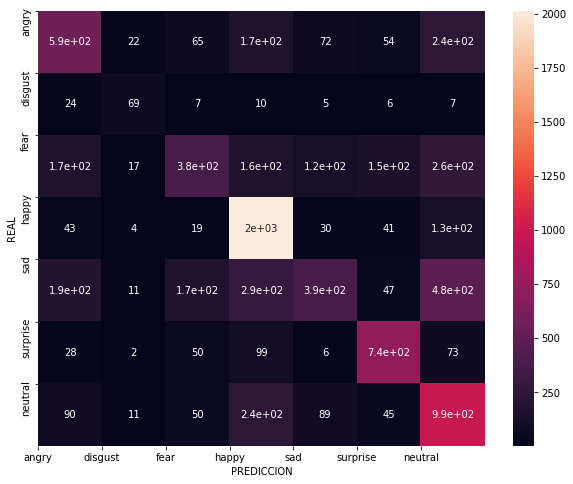

In [23]:
if (matrix==True):
    # llamamos a la funcion que pinta el porcentaje de acierto y la matriz
    my_matrix()

Como podemos apreciar la emocion 1 (disgust) no tiene buenos resultados.

### Funcion para realizar la predicion correspondiente.

In [24]:
def do_prediction(ImArray):

    porcentajes = model.predict(ImArray).tolist()
    #retornamos los datos de la prediccion en formato json
    return prepare_json(porcentajes)


### Funcion que prepara los resultados para devolver un json.

In [25]:
def prepare_json(porcentajes):
    jsons = {"expressions":[]}
    # recorremos los probabilidades de cada expresion
    a=porcentajes[0]
    for i in range(0,len(a)):
        # establecemos como maximo 3 decimales
        a[i] = round(a[i],3)
        jsons["expressions"].append({"mood":expressions[i],"probability":a[i]})
    # devolvemos un json con todas las probabilidades
    return jsons

### Funcion que prepara la foto recibida para que la CNN pueda interpretarla.

In [26]:
def prepare_photo(imagen):
    # convertimos la foto a gris y a tamaño 48x48
    img = imagen.convert('L').resize((48,48))
    # devolvemos un array con los pixeles de la foto
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = x / 255
    return x

### Peticion POST del lado del servidor.

In [27]:
app = Bottle()
@app.route("/getMood", method="POST")
def do_upload():
    
    foto = request.files["photo"]
    # usamos un archivo temporal para poder manipular la foto
    temporal = tempfile.TemporaryFile()
    foto.save(temporal)
    # es necesario que la foto tenga unas caracteristicas antes de ser mandada a la CNN, por ello primero se prepara
    imagen_lista = prepare_photo(Image.open(temporal))
    # realizamos la prediccion de la foto lista para poder ser interpretada por la CNN
    resultado = do_prediction(imagen_lista)
    # cerramos el archivo temporal
    temporal.close()
    
    print(resultado)
    
    return resultado

### Ejecutamos el servidor para que se puedan realizar peticiones.

In [28]:
run(app,host='192.168.1.46', port=9004, debug=True)

Bottle v0.12.18 server starting up (using WSGIRefServer())...
Listening on http://192.168.1.46:9004/
Hit Ctrl-C to quit.



{'expressions': [{'mood': 'angry', 'probability': 0.0}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.0}, {'mood': 'happy', 'probability': 0.001}, {'mood': 'sad', 'probability': 0.0}, {'mood': 'surprise', 'probability': 0.0}, {'mood': 'neutral', 'probability': 0.999}]}


192.168.1.33 - - [13/Apr/2020 14:19:16] "POST /getMood HTTP/1.1" 200 298


{'expressions': [{'mood': 'angry', 'probability': 0.0}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.0}, {'mood': 'happy', 'probability': 1.0}, {'mood': 'sad', 'probability': 0.0}, {'mood': 'surprise', 'probability': 0.0}, {'mood': 'neutral', 'probability': 0.0}]}


192.168.1.33 - - [13/Apr/2020 14:19:23] "POST /getMood HTTP/1.1" 200 294


{'expressions': [{'mood': 'angry', 'probability': 0.012}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.0}, {'mood': 'happy', 'probability': 0.984}, {'mood': 'sad', 'probability': 0.0}, {'mood': 'surprise', 'probability': 0.0}, {'mood': 'neutral', 'probability': 0.004}]}


192.168.1.33 - - [13/Apr/2020 14:19:28] "POST /getMood HTTP/1.1" 200 300


{'expressions': [{'mood': 'angry', 'probability': 0.015}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.0}, {'mood': 'happy', 'probability': 0.956}, {'mood': 'sad', 'probability': 0.001}, {'mood': 'surprise', 'probability': 0.0}, {'mood': 'neutral', 'probability': 0.028}]}


192.168.1.33 - - [13/Apr/2020 14:19:33] "POST /getMood HTTP/1.1" 200 302


{'expressions': [{'mood': 'angry', 'probability': 0.12}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.0}, {'mood': 'happy', 'probability': 0.818}, {'mood': 'sad', 'probability': 0.0}, {'mood': 'surprise', 'probability': 0.0}, {'mood': 'neutral', 'probability': 0.062}]}


192.168.1.33 - - [13/Apr/2020 14:19:37] "POST /getMood HTTP/1.1" 200 299
G:\Programs\Anaconda3\lib\site-packages\bottle.py:3139: ResourceWarning: unclosed <socket.socket fd=3816, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.46', 9004)>
  pass
